# **Using Gensim for Topic Modeling and Semantic Distance Calculation**

---

Date: Apr 6, 2021

Author: Jerónimo Arenas-García (jeronimo.arenas@uc3m.es), Jesús Cid-Sueiro (jcid@ing.uc3m.es)

Version 1.0

---

Our goal here is to present a basic overview of the library that covers the following aspects:

   - Document BoW and TFIDF representation
   - Topic Modeling
   - Word and Document Vector Representation
   - Semantic Similarity Calculation

In [1]:
# Common imports 
import numpy as np
import pandas as pd
import zipfile as zp
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [2]:
#To wrap long text lines
from IPython import get_ipython
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [3]:
#For fancy table Display
%load_ext google.colab.data_table

## **1. What is Gensim**

---

<figure>
<center>
<img src='https://radimrehurek.com/gensim_4.0.0/_images/gensim_logo_positive_complete_tb.png' width="600"></img>
<figcaption>Source: https://radimrehurek.com/gensim_4.0.0/_images/gensim_logo_positive_complete_tb.png</figcaption></center>
</figure>

Gensim is a Python library intended for NLP practitioners. It provides a variety of methods for working with documents in textual format and carrying out semantic analysis tasks such as topic modeling or semantic comparison between documents. For this reason, Gensim is also widely used in Information Retrieval (IR) tasks.

Gensim is Open Source and is entirely programmed in Python, so it is easy to modify the code if necessary. The source code is hosted on the [Github development repository](https://github.com/RaRe-Technologies/gensim
).

Despite being fully developed in Python, Gensim makes extensive use of the Numpy and Scipy libraries that provide highly efficient implementations of certain matrix transformations and mathematical calculations, so Gensim is quite fast. For this reason, Gensim has been adopted by a large number of companies as a core components of complex NLP systems. Gensim is available for its use in the main Cloud Computing platforms (AWS, Azure, Google, etc).


---
**Important**: 

There is a new release of Gensim released on March 24, 2021 (v4). This new version includes several improvements, mainly focused on the components of word and document embeddings. However, some tools designed to support third-party software, such as the Mallet wrapper, have been discontinued. For this reason, this Notebook makes use of Gensim v3.8.3 since it is the last release in which this wrapper is available. It is important to update to this version, since versions prior to 3.7 contain bugs in the use of said wrapper for Mallet.

Note also that this notebook will focus on Topic Modeling and Semantic Similarity calculation so our benefit from moving to v4 would be very limited at this point.

---

In [4]:
!pip install --upgrade gensim==3.8.3

     |████████████████████████████████| 24.2MB 38.2MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


### *1.1. Gensim Features*

Gensim offers multiple functions oriented to the calculation of vector representations of documents, to the modeling of topics, and to the calculation of semantic distances between documents. On the other hand, it does not offer a wide catalogue of functions for text preprocessing (e.g., lemmatization), so we will typically use Gensim on documents previously preprocessed with other specific libraries for this purpose, such as spaCy.

Gensim's design principles are:

   - **Reliability**: Inclusion of widely tested algorithms that can be deployed with guarantees in real systems. Like spaCy, it is not a particularly useful library from an academic point of view, although the fact that all its own code is developed in Python makes it easy to modify it for academic and research purposes.

   - **Scalability**: Gensim is programmed to allow working with large corpus of data. The implementations use data streaming that make it easy to iterate procedures over datasets that do not need to be stored in RAM memory (i.e., predominance of iterables over lists).

   - **Efficiency**: The use of Numpy and Scipy for expensive tasks, as well as the multicore implementation of various algorithms, provides efficient implementations of the included algorithms.

### *1.2. Gensim Algorithms*

The following algorithms are included in Gensim

   - Basic Text Preprocessing tools (Tokenizer, Porter Stemmer, stopword removal, short token removals). On the other hand, it includes an algorithm for N-gram identification that is based on efficient calculation of the frequency of terms co-occurrence.
   
   - Algorithms for Document Vectorization: From rawtext to Bag of Words or TFIDF representation.

   - Algorithms for Word and Document Vectorization based on Deep Neural Networks: Word2Vec, Doc2Vec, Fasttext. Pretrained models are available as well as the possibility to fine tune them or train from scratch. However, GPU optimization is not provided (you need to use PyTorch, Keras, ... for that).

   - Algorithms for Topic Modeling: Latent Semantic Indexing (LSI), Latent Dirichlet Allocation (LDA), Dynamic (LDA), Hierarchical Dirichlet Process (HDP), Non-negative Matrix Factorization (NMF). Topic coherence calculation.

   - Algorithms for computing semantic similarities: Among documents, among topics from the same or different models, among words, etc.

Gensim includes also a wide variety of utility functions to convert from Gensim representation to the text formats used by other common Topic Modeling libraries (e.g., Blei LDA implementation, Mallet).

For a complete description of all Gensim available tools, please refer to the [API documentation](https://radimrehurek.com/gensim_4.0.0/apiref.html).

### 1.3. *Gensim and other Libraries for NLP*

   - **spaCy** should be preferred for text preprocessing tasks. It offers more efficient and highly customizable NLP pipelines.
   - **scikit-learn**: should be preferred for classification or regression tasks. When this is the case, using sklearn TFIDF vectorizer followed by the classifier or regressor or your choice (including possibility of cross-validation of parameters) is extremely simple. Sklearn implementation for topic modeling is based on online LDA and could be a reasonable choice if we only care about the topics. However, Gensim offers more flexibility, a more memory efficient implementation, and a wide catalogue of support functions for semantic similarity. In short, it is more powerful than scikit learn for NLP and IR tasks.
   - **Blei LDA implementation**: It is the original implementation of the author of the LDA algorithm. It is very accurate with respect to LDA optimization. Being implemented in C is highly efficient, but cannot be parallelized. Furthermore, it requires specific text formats for the input and output data. If you want to use this implementation, Gensim can build these files for you.
   - **Mallet Topic Modeling Toolbox**: A very efficient Java implementation of LDA based on Monte Carlo sampling. Highly efficient and accurate. In my opinion, probably a the best implementation you can use for LDA regarding the performance vs accuracy balance. As said, it is implemented in Java, but the good news is that Gensim (up to v3.8) provides a wrapper for Mallet, so all you need to do is download the executable file, and tell Gensim where it can find it.

## **2. Gensim vectorization of documents**
---


### *2.1. Corpus loading*

When working with Gensim we need to manage collections of documents. In Gensim, a **document** is simply a list of tokens corresponding to a Python string, while a **corpus** is a collection of documents. The simplest way we can work with a corpus is to create a list of documents (i.e., a list of lists of tokens).

```
# This is a Gensim document
doc = ['Any', 'string', 'you', 'want', 'to', 'work', 'with']

# This is a Gensim corpus
corpus = [doc, 'A second document just to have more than one'.split()]
```

Gensim offers functionalities to create unsupervised models (e.g., topic modeling) based on collections of documents, as well as to measure semantic similarities between words, documents, topics, etc.



**Exercise 1:** Generate a corpus to be used in this tutorial. In order to obtain good results, it is recommended that the generated corpus has been previously preprocessed and lemmatized using the pipeline that you implemented in the spaCy Tutorial. You can use the preprocessed data from the NSF dataset, or any other data source you have generated. 

It is recommended to keep the number of documents around 10,000. In this way, you will be able to train the models in a reasonable time during the execution of the tutorial. An excessively low number of documents will make the trained topic models poorly interpretable.

If you do not yet have a preprocessed set of documents as described, you can use the subset of NSF pre-processed data available in file *NSF2018_lemmas.txt*. Each line of the file corresponds to a different document.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
root_path = '/content/gdrive/My Drive/ML Applications/Natural Language Processing/NSF2018_lemmas.txt'  
with open(root_path, "r") as corpus:
    CorpusContent = corpus.readlines()
    print(CorpusContent)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
#<SOL>
mycorpus = [el.strip().split() for el in CorpusContent]
#</SOL>
print(colored('Number of documents in corpus: '+str(len(mycorpus)), 'green'))
print(colored('\n============= First document in corpus =============', 'blue'))
print(mycorpus[0])
print(colored('\n============= Corresponding Python string =============', 'blue'))
print(' '.join(mycorpus[0]))

Number of documents in corpus: 9446

============= First document in corpus =============
['molecular', 'mechanisms', 'bacterial', 'helicase', 'assembly', 'activation', 'replication', 'origin', 'goal', 'work', 'understand', 'essential', 'feature', 'dna', 'replication', 'structure', 'analysis', 'assembly', 'bacterial', 'dnab', 'replicative', 'helicase', 'origin', 'dna', 'replication', 'replicative', 'helicase', 'unwind', 'duplex', 'dna', 'template', 'replication', 'contrast', 'extensive', 'understanding', 'translocation', 'dnab', 'single', 'strand', 'dna', 'ssdna', 'little', 'know', 'mechanism', 'helicase', 'opening', 'helicase', 'assembly', 'ssdna', 'closing', 'helicase', 'mediate', 'helicase', 'loader', 'research', 'address', 'main', 'mission', 'scientist', 'teacher', 'attract', 'retain', 'student', 'stem', 'science', 'technology', 'engineering', 'mathematic', 'field', 'prepare', 'educate', 'citizenry', 'century', 'city', 'college', 'new', 'york', 'ccny', 'additional', 'mission', 'pro

**Exercise 2:** Calculate the average number of tokens per document, and plot the histogram of the number of tokens per document

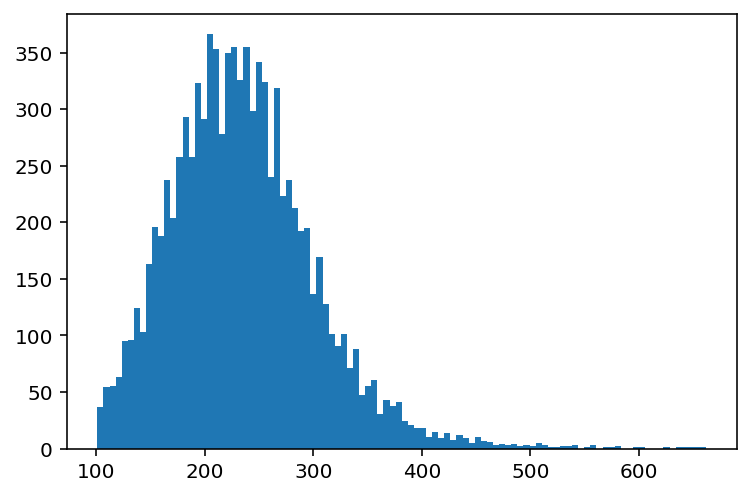

In [8]:
#<SOL>
import numpy as np
ls = []
for i in mycorpus:
   ls.append(len(i))
np.mean(ls)
plt.hist(ls,100)
plt.show()
#</SOL>

In order to be able to work with the corpus, we need to vectorize all its documents. To do so, there are two steps we need to carry out:

1. Calculate the dictionary
2. Transform the documents using the dictionary

Optionally, we can also use Gensim to carry out an additional pre-processing stage which is useful for topic modeling: 

0. N-gram detection.

This step could be implemented using the NER component of spaCy, but we already checked that the performance of that component could be rather poor for documents belonging to certain domains.

### *2.2. N-gram detection and replacement*

Gensim N-gram detection is purely based on the detection of tokens that appear next to each other with high frequency. In fact, Gensim `Phraser` can be parameterized to allow some intermediate tokens which are normally considered as links tokens in English language. However, since we have already carry out lemmatization and stopword removal we can make use a very simple use of the method.

Two parameters are necessary:
   - `min_count`: Minimum length for N-grams
   - `threshold`: Minimum scoring for accepting N-grams. Higher values imply that fewer N-grams are accepted. The threshold is applied on a scoring function that depends on the frequency of the detected N-grams, as well as on the number of isolated occurrences of the component tokens.

In [9]:
from gensim.models.phrases import Phrases

phrase_model = Phrases(mycorpus, min_count=2, threshold=20)

print(colored('\n============= First document in corpus =============', 'blue'))
print(mycorpus[0])
mycorpus = [el for el in phrase_model[mycorpus]] #We populate mycorpus again
print(colored('\n============= First document after N-gram replacement =============', 'blue'))
print(mycorpus[0])



============= First document in corpus =============
['molecular', 'mechanisms', 'bacterial', 'helicase', 'assembly', 'activation', 'replication', 'origin', 'goal', 'work', 'understand', 'essential', 'feature', 'dna', 'replication', 'structure', 'analysis', 'assembly', 'bacterial', 'dnab', 'replicative', 'helicase', 'origin', 'dna', 'replication', 'replicative', 'helicase', 'unwind', 'duplex', 'dna', 'template', 'replication', 'contrast', 'extensive', 'understanding', 'translocation', 'dnab', 'single', 'strand', 'dna', 'ssdna', 'little', 'know', 'mechanism', 'helicase', 'opening', 'helicase', 'assembly', 'ssdna', 'closing', 'helicase', 'mediate', 'helicase', 'loader', 'research', 'address', 'main', 'mission', 'scientist', 'teacher', 'attract', 'retain', 'student', 'stem', 'science', 'technology', 'engineering', 'mathematic', 'field', 'prepare', 'educate', 'citizenry', 'century', 'city', 'college', 'new', 'york', 'ccny', 'additional', 'mission', 'provide', 'high', 'quality', 'education

You can check that detected N-grams are created by linking together the corresponding tokens using the underscore character.

**Exercise 3:** Create a table containing all detected N-grams and the number of ocurrences of each N-gram in the corpus.

   - How many N-grams did the method identify?
   - What are the most frequent N-grams in the corpus?

In [10]:
#<SOL>
from collections import Counter
N_gram = []
for doc in mycorpus:
  for elem in doc:
    if '_' in elem:
      N_gram.append(elem)

  
df = pd.DataFrame.from_dict(Counter(N_gram), orient='index').reset_index()
df = df.rename(columns={'index':'Ngram', 0:'count'})
df
#</SOL>
# Ngrams_df

Output hidden; open in https://colab.research.google.com to view.

### *2.3. Computing the dictionary*

As a first step for vectorizing documents, we need to create a dictionary containing all tokens in our text corpus, and assigning an integer identifier to each one of them.

The following code fragment generates such dictionary and shows the first tokens in the dictionary. 

---
Note: We will proceed without N-gram detection since we did not carry out a careful selection of the threshold. If you want to keep N-grams, you just need to comment the first two lines of the code fragment, but a finer tuning of the N-gram model is advised to get higher quality topics.

---

In [12]:
mycorpus[0:100]

[['molecular',
  'mechanisms',
  'bacterial',
  'helicase',
  'assembly',
  'activation',
  'replication',
  'origin',
  'goal',
  'work',
  'understand',
  'essential',
  'feature',
  'dna',
  'replication',
  'structure',
  'analysis',
  'assembly',
  'bacterial',
  'dnab',
  'replicative',
  'helicase',
  'origin',
  'dna',
  'replication',
  'replicative',
  'helicase',
  'unwind',
  'duplex',
  'dna',
  'template',
  'replication',
  'contrast',
  'extensive',
  'understanding',
  'translocation',
  'dnab',
  'single',
  'strand',
  'dna',
  'ssdna',
  'little',
  'know',
  'mechanism',
  'helicase',
  'opening',
  'helicase',
  'assembly',
  'ssdna',
  'closing',
  'helicase',
  'mediate',
  'helicase',
  'loader',
  'research',
  'address',
  'main',
  'mission',
  'scientist',
  'teacher',
  'attract',
  'retain',
  'student',
  'stem',
  'science',
  'technology',
  'engineering',
  'mathematic',
  'field',
  'prepare',
  'educate',
  'citizenry',
  'century',
  'city',
  'col

In [13]:
with open(root_path, "r") as corpus:
    CorpusContent = corpus.readlines()
mycorpus = [el.strip().split() for el in CorpusContent]


from gensim.corpora import Dictionary

# Create dictionary of tokens
D = Dictionary(mycorpus)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 36402 terms
First terms in the dictionary:
0 : activation
1 : additional
2 : address
3 : adoption
4 : aim
5 : analysis
6 : assembly
7 : associate
8 : attention
9 : attract


The dictionary object contains a number of attributes and methods that can be useful for carrying out some cleaning tasks. You can check the available methods using 
```
dir(D)
```
Some of the most useful methods that we will use are:
   - ```add_documents```: updates the dictionary processing new documents
   - ```merge_with```: merges two dictionaries
   - ```save```, ```save_as_text```, ```load```, ```load_from_text```: can be used to give persistence to the dictionary and reading a previously calculated dictionary
   - ```id2token```: This is a Python dictionary for the mapping tokenid (a number) -> token (text representation). You can check that ```D[n]``` is equivalent to ```D.id2token[n]```
   - ```token2id```: A Python dictionary for the reverse mapping token -> tokenid
   - ```items```, ```keys```, ```values```, ```iteritems```, ```iterkeys```, ```itervalues```: Can be used to obtain al items (tokenid, token), all tokenids, or all token texts, or to iterate over them.
   - ```dfs```: A Python dictionary for the mapping tokenid -> Number of documents where the token appears
   - ```filter_tokens```, ```filter_extremes```, ```filter_n_most_frequent```: are used to remove elements from the dictionary, and ```compactify```is used to reassign tokenids to tokens for a more efficient representation.
   - ```doc2bow```: converts a document into its Bag of Words Representation
   - ```doc2idx```: transforms a document into a sequence of the tokenids of the words of the document

**Exercise 4**:

1. Obtain a dataframe with 2 columns: `token` and `ndocs`, corresponding to the text of each token and the number of documents where the token appears

2. Sort the dataframe according to column `ndocs`. 

3. How many tokens appear in exactly one document? Remove them from the dataframe.

4. What are the most and less common tokens in the dictionary in terms document occurrence?

3. Plot a histogram of the number of token appearances


In [14]:
#<SOL>
from google.colab import data_table

token_lst = {}
for i in D.itervalues():
  token_lst[i] = D.dfs[D.token2id[i]]


df = pd.DataFrame.from_dict(token_lst, orient='index').reset_index()
df = df.rename(columns={'index':'Token', 0:'ndocs'})
data_table.DataTable(df, include_index=False)
print('Number of Tokens that appear in just one Doc: ',sum(df['ndocs'] == 1))
df = df[df['ndocs'] != 1]
df

#</SOL>

Output hidden; open in https://colab.research.google.com to view.

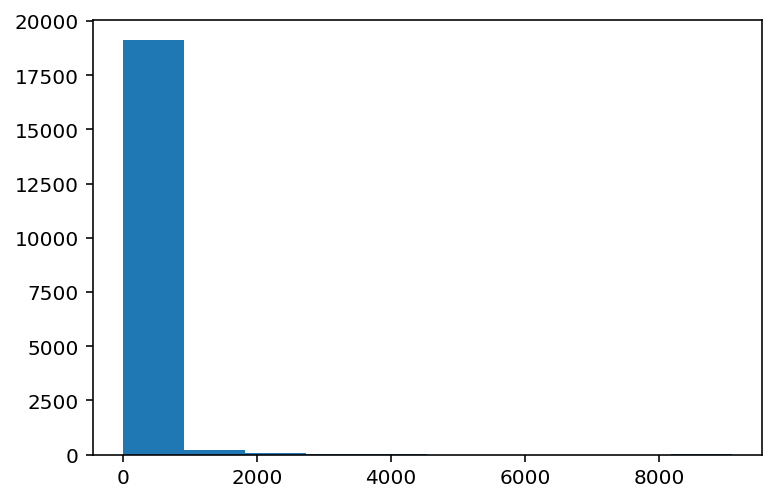

In [ ]:
plt.hist(df['ndocs'])
plt.show()

# fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
# fig.suptitle('Different abstract lenghts')
# sns.histplot(ax=df['ndocs'],x=pd.Series())

Next, we will filter out terms that appear in too few or too many of the documents in the dataset. This makes sense because:

   - terms that appear in most documents are probably not very informative in the general context of a particular corpus
   - terms that appear in a very reduced number of documents are not useful to find repetitive patterns across documents. In fact, in many cases we find that many of the words that are eliminated for this reason can be typos.

In [ ]:
no_below = 4 #Minimum number of documents to keep a term in the dictionary
no_above = .80 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

The dictionary contains 12453 terms


You can check dictionary size has been considerably reduced with respect to the original vocabulary.

### *2.4. Document vectorization*

Next, let us create a numerical version of our corpus using the `doc2bow` method. In general, `D.doc2bow(token_list)` transforms any list of tokens into a list of tuples `(token_id, n)`, one per each token in `token_list`, where `token_id` is the token identifier (according to dictionary `D`) and `n` is the number of occurrences of such token in `token_list`. 

In [ ]:
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]

n_project = 1000
print(colored('============= Project abstract (lemmas) =============', 'blue'))
print(' '.join(mycorpus[n_project]))

print(colored('\n============= Sparse vector representation =============', 'blue'))
print(mycorpus_bow[n_project])

print(colored('\n============= Word counts for the project =============', 'blue'))
print(list(map(lambda x: (D[x[0]], x[1]), mycorpus_bow[n_project])))

============= Project abstract (lemmas) =============
statistical mechanic area theoretical physics predict macroscopic behavior physical system give microscopic dynamic dynamic classical quantum equilibrium statistical mechanic foundational work go boltzmann gibbs formulate principle procedure microscopic dynamic description macroscopic system carry procedure difficult broad outline understand physical system equilibrium main interest long time behavior gaussian distribution familiar bell shape curve important universality apply wide variety unrelated problem underlie common theme problem fact object study degree independence state physical term non interact interact type problem understand foundation nonequilibrium statistical physics understand equilibrium statistical physics particular process involve interact particle project direct understand process interact satisfactory general theory exist non interact case model occupy big role understand system equilibrium asymmetric exclusi

Note that we can interpret each element of corpus_bow as a `sparse_vector`. For example, a list of tuples 

    [(0, 1), (3, 3), (5,2)] 

for a dictionary of 10 elements can be represented as a vector, where any tuple `(id, n)` states that position `id` must take value `n`. The rest of positions must be zero.

    [1, 0, 0, 3, 0, 2, 0, 0, 0, 0]

These sparse vectors will be the inputs to the topic modeling algorithms.

As a summary, we have obtained the following variables that will be relevant for the next sections:

   * `D`: A gensim dictionary. Term strings can be accessed using the numeric identifiers. For instance, `D[0]` contains the string corresponding to the first position in the BoW representation.
   * `mycorpus_bow`: BoW corpus. A list containing an entry per project in the dataset, and consisting of the (sparse) BoW representation for the abstract of that project.

### *2.5. TFIDF vectorization*

Gensim TFIDF representation of a document is computed as

$$x_{ij} = \text{freq}_{ij} \log_2 \frac{\# docs}{\# docs_j}$$

where: 

   - $x_{ij}$ is the component of the TFIDF representation of document $i$ corresponding to term $j$
   - $\text{freq}_{ij}$ is the frequency of term $j$ in document $i$ (i.e., number of ocurrences divided by the number of tokens)
   - $\# docs$ is the total number of documents in the corpus
   - ${\# docs_j}$ is the number of documents in the corpus containing term $j$

In this way, terms that appear in fewer documents get emphasized over common terms appearing in many documents.

Gensim offers the possibility to change the *term frequency* and *inverse document frequency* calculation terms, but we will keep the defaults.

Note that, contrary to the Bag of Words (BoW) representation, the TFIDF representation does not depend just on the tokens of each document, but gets affected by the whole corpus through the IDF factor.

Gensim considers TFIDF as a model on its own, and deals with it similarly to what is done with other models. Creating a TFIDF model is very simple

In [ ]:
from gensim.models import TfidfModel

tfidf = TfidfModel(mycorpus_bow)


A **TFIDF model cannot be updated** adding more documents. Otherwise, we would lose consistency, i.e., the TFIDF representation for a particular document would change before and after the TFIDF model gets updated.

From now on, `tfidf` can be used to convert any vector from the old representation (bow integer counts) to the new one (TFIDF real-valued weights), or to apply a transformation to a whole corpus



In [ ]:
#Notice square brackets
mycorpus_tfidf = tfidf[mycorpus_bow]
n_project = 1000
print(colored('============= TFIDF representation for the project =============', 'blue'))
print(mycorpus_tfidf[n_project])

print(colored('\n============= TFIDF applying the transformation only to the document =============', 'blue'))
print(tfidf[mycorpus_bow[n_project]])


============= TFIDF representation for the project =============
[(44, 0.04036036821890844), (46, 0.034178690719234905), (60, 0.035569315170911414), (72, 0.037402586636872785), (75, 0.04406373674938159), (83, 0.06892871858851884), (85, 0.01663198295603937), (101, 0.06696645207782019), (138, 0.08229344302760319), (140, 0.027763426675780613), (160, 0.03336421159569198), (181, 0.03299384220295223), (220, 0.06518218966149723), (232, 0.05050413708212838), (239, 0.0860195959996164), (240, 0.09580169888008228), (263, 0.04745385437708976), (300, 0.04326959101863456), (318, 0.21725890517156596), (319, 0.03011708337717091), (340, 0.06655587735495105), (359, 0.019591595612315264), (361, 0.021655796320805883), (362, 0.05760178045366014), (364, 0.017318710144783627), (369, 0.028897366553777858), (374, 0.03143037087935588), (378, 0.020761857239006073), (399, 0.02437230819683857), (422, 0.06683464029026306), (442, 0.029081284383716793), (457, 0.2720796278446136), (466, 0.03011708337717091), (473, 0.0

As for BOW, TFIDF provides a sparse document representation.

### *2.6. Memory efficient Dictionary and Corpus Vector representations*



In the previous examples, the construction of the dictionary and the transformation of the corpus to BoW or TFIDF format required that said corpus of documents be available in a list in the execution environment, and therefore required it to be stored in RAM memory. For small corpus this is not a problem, but it can be an important limitation when dealing with large corpus with millions or tens of millions of documents. These corpora are becoming more and more common in certain applications (consider wikipedia entries, user opinions on large e-commerce platforms, processing of medical records, etc.).

One of the advantages of Gensim is that its implementation makes it easy to work with a corpus of these sizes. As explained in the Gensim documentation:

> Note that corpus above resides fully in memory, as a plain Python list. In this simple example, it doesn’t matter much, but just to make things clear, let’s assume there are millions of documents in the corpus. Storing all of them in RAM won’t do. Instead, let’s assume the documents are stored in a file on disk, one document per line. Gensim only requires that a corpus must be able to return one document vector at a time.

>The full power of Gensim comes from the fact that a corpus doesn’t have to be a list, or a NumPy array, or a Pandas dataframe, or whatever. Gensim accepts any object that, when iterated over, successively yields documents.





The next fragment of code illustrates how the dictionary can be created from a corpus stored in a text file. You just need to create an iterator that returns a document at each iteration, and keep adding documents to the dictionary. Note that during the execution of the code, only one document is kept in memory at every iteration.

In [ ]:
class IterableCorpus_fromfile:
    def __init__(self, filename):
        self.__filename = filename
    def __iter__(self):
        for line in open(self.__filename,'r'):
            # assume there's one document per line, tokens separated by whitespace
            yield line.lower()


MyIterCorpus = IterableCorpus_fromfile(root_path)
newD = Dictionary()
for doc in MyIterCorpus:
  newD.add_documents([doc.split()])
no_below = 4 #Minimum number of documents to keep a term in the dictionary
no_above = .80 #Maximum proportion of documents in which a term can appear to be kept in the dictionary
newD.filter_extremes(no_below=no_below,no_above=no_above)


The code above can be further simplified if the iterator already carries out the tokenization of each document. In that case, the dictionary can be created with a simple command:

In [ ]:
class IterableCorpus_fromfile:
    def __init__(self, filename):
        self.__filename = filename
    def __iter__(self):
        for line in open(self.__filename,'r'):
            # assume there's one document per line, tokens separated by whitespace
            yield line.lower().split()


MyIterCorpus = IterableCorpus_fromfile(root_path)
newD = Dictionary(MyIterCorpus)
no_below = 4 #Minimum number of documents to keep a term in the dictionary
no_above = .80 #Maximum proportion of documents in which a term can appear to be kept in the dictionary
newD.filter_extremes(no_below=no_below,no_above=no_above)

print('Number of documents processed:', newD.num_docs)
print('Number of elements in dictionary:', len(newD))


Number of documents processed: 9446
Number of elements in dictionary: 12453


### *2.7. Compatibility with Numpy and Scipy*

Gensim contains efficient functions to convert Gensim Corpus (BoW, TFIDF, or yet to see LSI and LDA) to Numpy dense matrices or Scipy Sparse Matrices. This can be useful, e.g., if we wish to use the vectorial representation of a Gensim corpus to train a classification or regression model using sklearn.

Similarly, we also have functions to convert Numpy or Scipy matrices into Gensim representation.

More information on the available utilities can be found in the [Gensim API matutils documentation](https://radimrehurek.com/gensim/matutils.html).


## **3. Topic Modeling with Gensim**
---


### *3.1. Latent Semantic Indexing*

Now we are ready to apply a topic modeling algorithm. Latent Semantic Indexing (LSI) is provided by LsiModel. Note that LSI by carryint out the SVD of either the BoW or TFIDF data representation matrices. However, it is generally accepted that better results are obtained from LSI when using the TFIDF representation.

**Exercise 5**: Generate an LSI model with 10 topics for `mycorpus_tfidf` and dictionary `D`. You can check the sintaxis for [gensim.models.LsiModel](https://radimrehurek.com/gensim/models/lsimodel.html) in order to solve the exercise.

In [ ]:
from gensim.models import LsiModel

# Initialize an LSI transformation
n_topics = 10

lsi =  LsiModel(mycorpus_tfidf , id2word=D,num_topics=n_topics)
vectorized_corpus = lsi[mycorpus_tfidf ] 

From LSI, we can check both the topic-tokens matrix and the document-topics matrix.

   - `topic-tokens` matrix provides the weight (either positive or negative) that each token has for every token. Note that token relevance is normally measured from the absolute value of the weight, with positive/negative weights corresponding to tokens that are important/uncorrelated with the topic.

   - `document-topics`matrix provides the weight (either positive or negative) of each topic for a particular document. Topics with a positive weight are positively correlated with the document, whereas negative weights imply a negative contribution of the topic for the document. 

#### 3.1.1. Displaying topic information


A first visualization of the obtained topics is provided by the `show_topics` method.

In [ ]:
#Display all topics including 10 most relevant tokens per topic
# lsi.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

A more useful representation of a particular topic can be obtained using the `show_topic` method that returns a list of tuples (token, value). This is provided by the show_topic method. Check below the output of this function for a particular topic. The function returns the requested number of tokens sorted by decreasing absolute value of the topic-weight.

In [ ]:
lsi.show_topic(3, topn=10)

[('quantum', -0.43827379868850574),
 ('conference', -0.2387929266117058),
 ('theory', -0.18622022771439622),
 ('cell', 0.14366232775317211),
 ('physics', -0.1343703981218309),
 ('geometry', -0.13388233915487344),
 ('water', 0.11752354562026973),
 ('algebraic', -0.10978052003614355),
 ('equation', -0.10747174091397121),
 ('mathematical', -0.10479173130722527)]

**Exercise 6:** Complete the following code fragment to represent the columns of the topic-token matrix as a series of bar diagrams (one per topic) with the top 25 tokens of each topic.

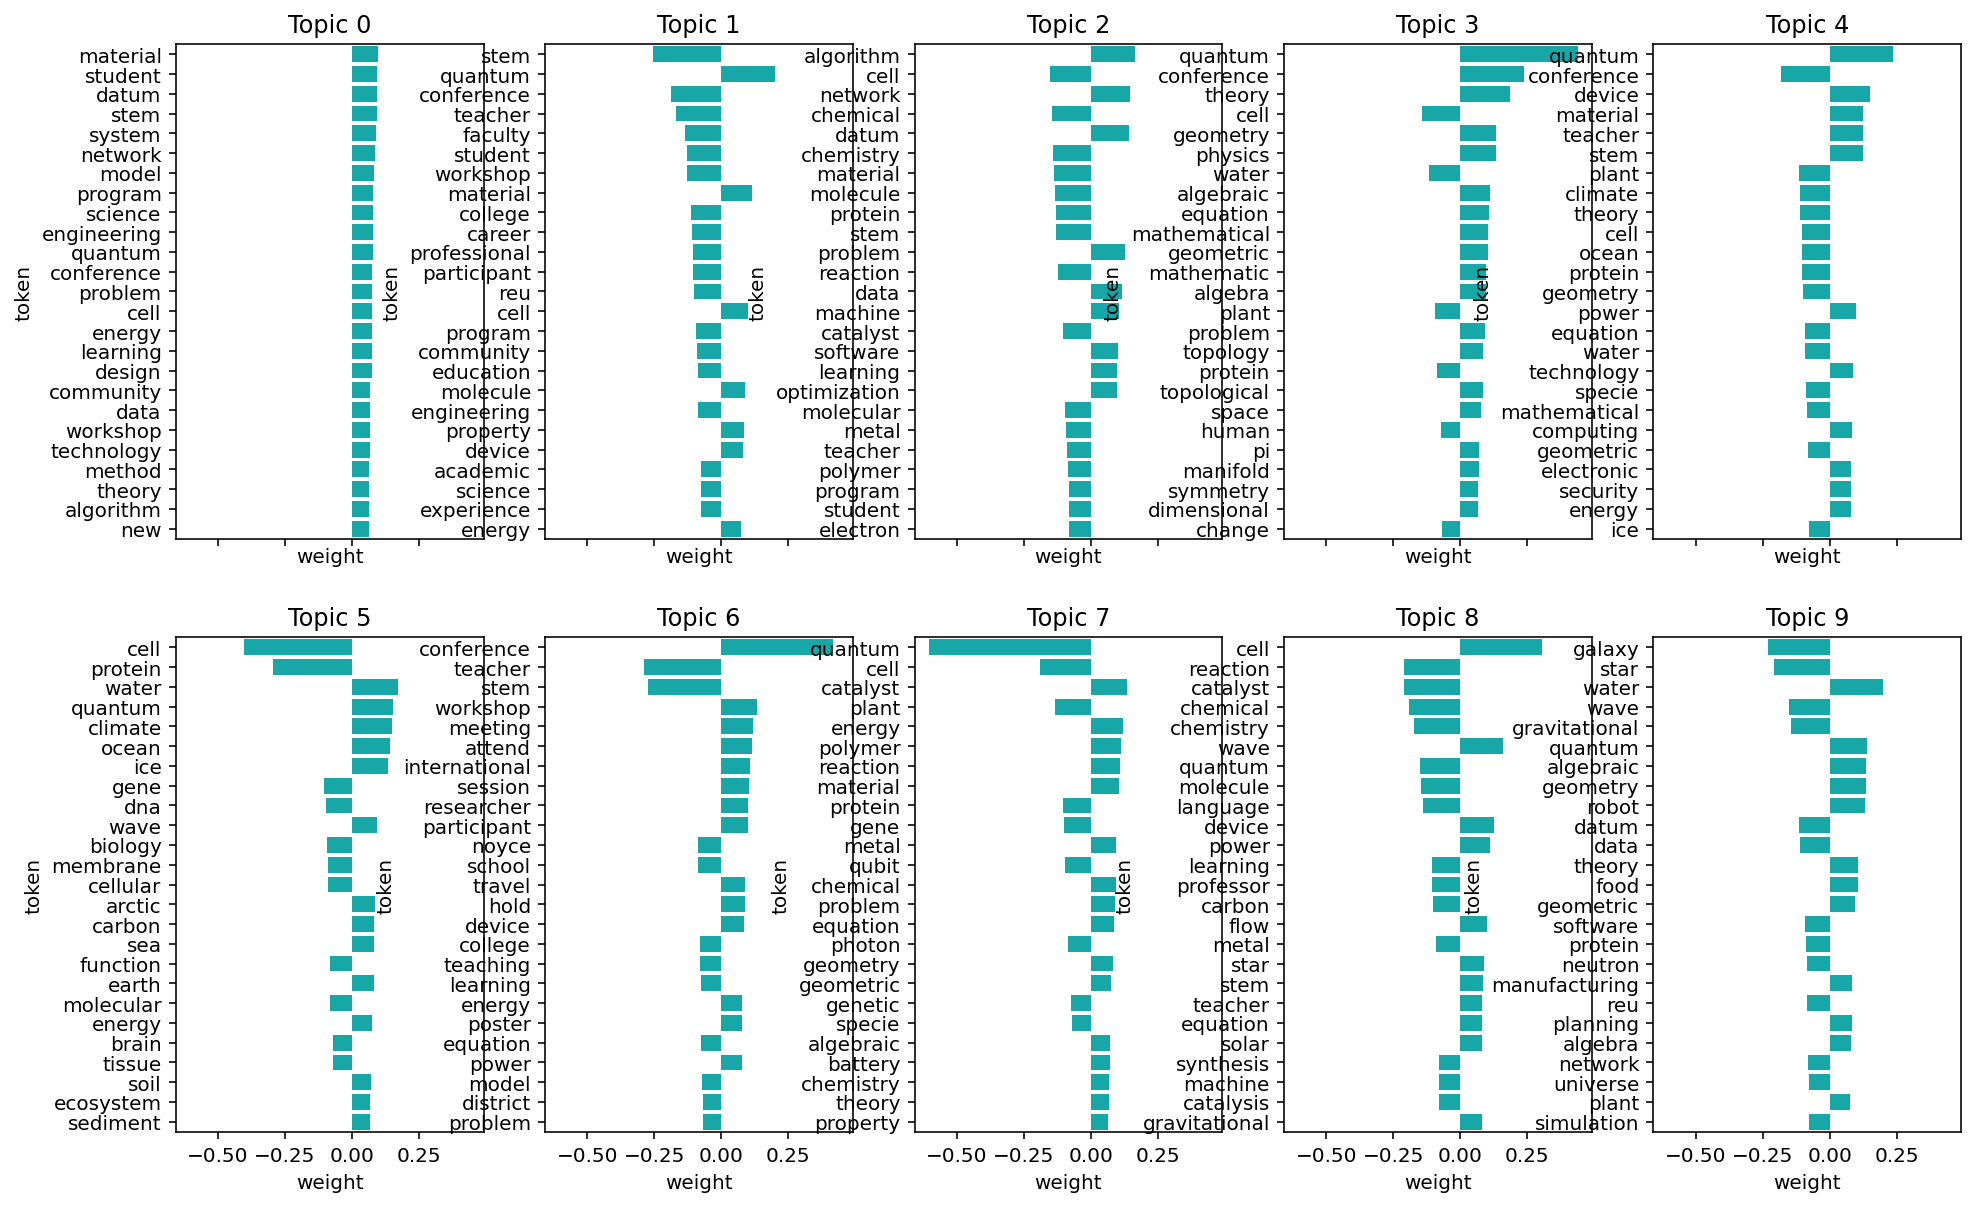

In [ ]:
topn = 25

fig, axes = plt.subplots(2, 5, figsize=(16, 10), sharex=True)

for i in range(5):

    #<SOL>
    # Build a dataframe with columns 'token' and 'weight' for topic i
    df =  pd.DataFrame(lsi.show_topic(i, topn = 25), columns =['token', 'weight'])
    #</SOL>
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))
    #<SOL>
    # Build a dataframe with columns 'token' and 'weight' for topic i + 5
    df = pd.DataFrame(lsi.show_topic(i+5, topn = 25), columns =['token', 'weight'])
    #</SOL>
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+5))
    
plt.show()


**Discussion**: 

   - Taking a look at the previous plots, can you find some intuitive topics?
   - Can you distinguish the significance of positive vs negative weights?
   - Which terms would you keep to better characterize the topics: positive, negative, both?
   - What do you think is the role of Topic 0?

You can play with changing the number of topics to check whether you can find more detailed topics. Normally, more detailed topics come at the cost of adding some noisy topics. 

#### 3.1.2. Displaying document topic information

LSI approximates any document as a linear combination of the topic vectors. We can compute the topic weights for any input corpus entered as input to the lsi model.

Notice that, from the point of view of Gensim, the lsi model constitutes a transformation, just like the tfidf object. This means that:

   - You can use it to obtain the LSI representation of a particular document or to transform a whole corpus.
   - You can use a transformed corpus as document feature representation for another Machine Learning Task. For instance, you could try to solve a classification or regression task using the LSI representation of each document as the input to the classifier/regression model, as you would do with the BoW or TFIDF vectors

As LSI is based on SVD decomposition, the topic representation of any document will generally contain non-zero weights for all topics.

As with other Gensim objects, you can serialize the LSI model for future use. In order to save the model, use the `save` method of the `gensim.models.lsimodel` object.

In [ ]:
corpus_lsi = lsi[mycorpus_tfidf]
print(corpus_lsi[0])

[(0, 0.06554498891006205), (1, 0.00924159699956222), (2, -0.032414029200142164), (3, -0.015383491061015483), (4, -0.026899829370935824), (5, -0.051213127016935436), (6, -0.01644996836151388), (7, -0.01721452764331142), (8, -0.002345110209238226), (9, -0.002812083784327782)]


**Exercise 7**: Try to locate a topic related to *Astrophysics*, and find the most relevant document for such topic. In order to do so, you should take into account whether the relevant tokens for the topic have been assigned positive or negative values in the `topic-tokens` matrix. The *most relevant document* will be that with the largest or smallest component for the topic.

Observe the document text representation to check whether the selected document was reasonably characterized by the topic.

(If you are working with your own dataset, pick another topic from the model you obtained)

In [ ]:
# Clearly Topic 9 is the one which is more related with Astrophysics
lsi.show_topic(9, topn = 25)

[('galaxy', -0.23118728161232702),
 ('star', -0.2096643890747856),
 ('water', 0.19976694247124488),
 ('wave', -0.15269698607228854),
 ('gravitational', -0.14317341154999327),
 ('quantum', 0.1393861022272019),
 ('algebraic', 0.13557020619247376),
 ('geometry', 0.13537450374623625),
 ('robot', 0.13008353628096428),
 ('datum', -0.11518950513173391),
 ('data', -0.11119749172396101),
 ('theory', 0.1055660559232435),
 ('food', 0.10478069076260216),
 ('geometric', 0.09428962907069739),
 ('software', -0.09123984029081916),
 ('protein', -0.08998660561058018),
 ('neutron', -0.08596852155355203),
 ('manufacturing', 0.08476981990459351),
 ('reu', -0.08356298423811784),
 ('planning', 0.0817888890843021),
 ('algebra', 0.08047988613996773),
 ('network', -0.07994155773408412),
 ('universe', -0.07708465805025128),
 ('plant', 0.07668920815603639),
 ('simulation', -0.07616532031739862)]

In [ ]:
#<SOL>
from gensim import matutils
tpc_selected = 9
lsi_dense = matutils.corpus2dense(corpus_lsi,num_terms=10,num_docs=len(corpus_lsi))

# selected_doc = np.argmin(lsi_dense[tpc_selected,:])
selected_doc = np.argmax(lsi_dense[tpc_selected,:])

print('Position of selected document:', selected_doc)
print('Weight of selected document for the topic:', lsi_dense[tpc_selected,selected_doc])
print(colored('\n============= Text (lemmas) of most relecant document =============', 'blue'))
print(mycorpus[selected_doc])
#</SOL>

Position of selected document: 8455
Weight of selected document for the topic: 0.25195235

============= Text (lemmas) of most relecant document =============
['city', 'globe', 'face', 'difficult', 'challenge', 'manage', 'food', 'water', 'energy', 'system', 'challenge', 'stem', 'fact', 'issue', 'food', 'water', 'energy', 'connect', 'know', 'food', 'water', 'energy', 'fwe', 'nexus', 'effective', 'solution', 'local', 'water', 'problem', 'cause', 'new', 'local', 'problem', 'food', 'energy', 'cause', 'new', 'water', 'problem', 'global', 'level', 'local', 'scale', 'difficult', 'anticipate', 'solution', 'issue', 'nexus', 'sustainable', 'food', 'water', 'energy', 'system', 'local', 'global', 'scale', 'innovative', 'solution', 'encompass', 'nexus', 'important', 'enable', 'city', 'manage', 'food', 'water', 'energy', 'system', 'understand', 'benefit', 'tradeoff', 'different', 'solution', 'award', 'support', 'researcher', 'participate', 'project', 'select', 'country', 'initiative', 'joint', 'belm

### *3.2. Latent Dirichlet Allocation*

Since we already have computed the dictionary and documents BoW representation using Gensim, computing the topic model is straightforward using the `LdaModel()` function. 

Like the implementation in scikit-learn, Gensim LDA is based on [Online LDA](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.984.3103&rep=rep1&type=pdf). Gensim implementation is:
   - *memory efficient*: the input data (BoW representation) just need to be a Python iterator. This means that the corpus does not have to reside in memory allowing to train with corpus larger than the available RAM. 
   - *distributed*: allows training using multiple cores for faster execution.

Please, refer to [Gensim API documentation](https://radimrehurek.com/gensim/models/ldamodel.html) for more information on the different parameters accepted by the function. Take a look at the possible choices for the parameters related LDA Dirichlet prior hyperparameters `alpha`, and `eta`.

**Important**: Unlike LSI, LDA generative model is based on BoW document representation. Therefore, you should **always** use BoW representation when searching for LDA models.


In [ ]:
from gensim.models.ldamodel import LdaModel
num_topics = 20

ldag = LdaModel(corpus=mycorpus_bow, id2word=D, num_topics=num_topics)

#### 3.2.1. Displaying topic information

A first visualization of the obtained topics is provided by the show_topics method.

In [ ]:
#Display all topics including 10 most relevant tokens per topic
ldag.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

[(0,
  '0.012*"carbon" + 0.009*"water" + 0.009*"ocean" + 0.006*"microbial" + 0.006*"sediment" + 0.006*"study" + 0.006*"process" + 0.006*"chemical" + 0.005*"nitrogen" + 0.005*"provide"'),
 (1,
  '0.017*"datum" + 0.010*"develop" + 0.009*"system" + 0.008*"software" + 0.007*"new" + 0.006*"information" + 0.006*"tool" + 0.006*"use" + 0.006*"model" + 0.006*"analysis"'),
 (2,
  '0.011*"molecule" + 0.010*"new" + 0.009*"material" + 0.009*"molecular" + 0.009*"chemical" + 0.008*"student" + 0.008*"chemistry" + 0.008*"high" + 0.007*"structure" + 0.007*"study"'),
 (3,
  '0.013*"system" + 0.010*"control" + 0.008*"plant" + 0.008*"human" + 0.007*"gene" + 0.006*"robot" + 0.005*"genetic" + 0.005*"provide" + 0.005*"develop" + 0.005*"dna"'),
 (4,
  '0.010*"social" + 0.008*"study" + 0.007*"datum" + 0.007*"community" + 0.006*"science" + 0.005*"change" + 0.005*"work" + 0.005*"provide" + 0.005*"develop" + 0.005*"policy"'),
 (5,
  '0.018*"theory" + 0.016*"conference" + 0.015*"student" + 0.011*"problem" + 0.009*"

**Exercise 8:** Like you did for the LSI model, provide a graphic interpretation of token composition of the topics you obtained.

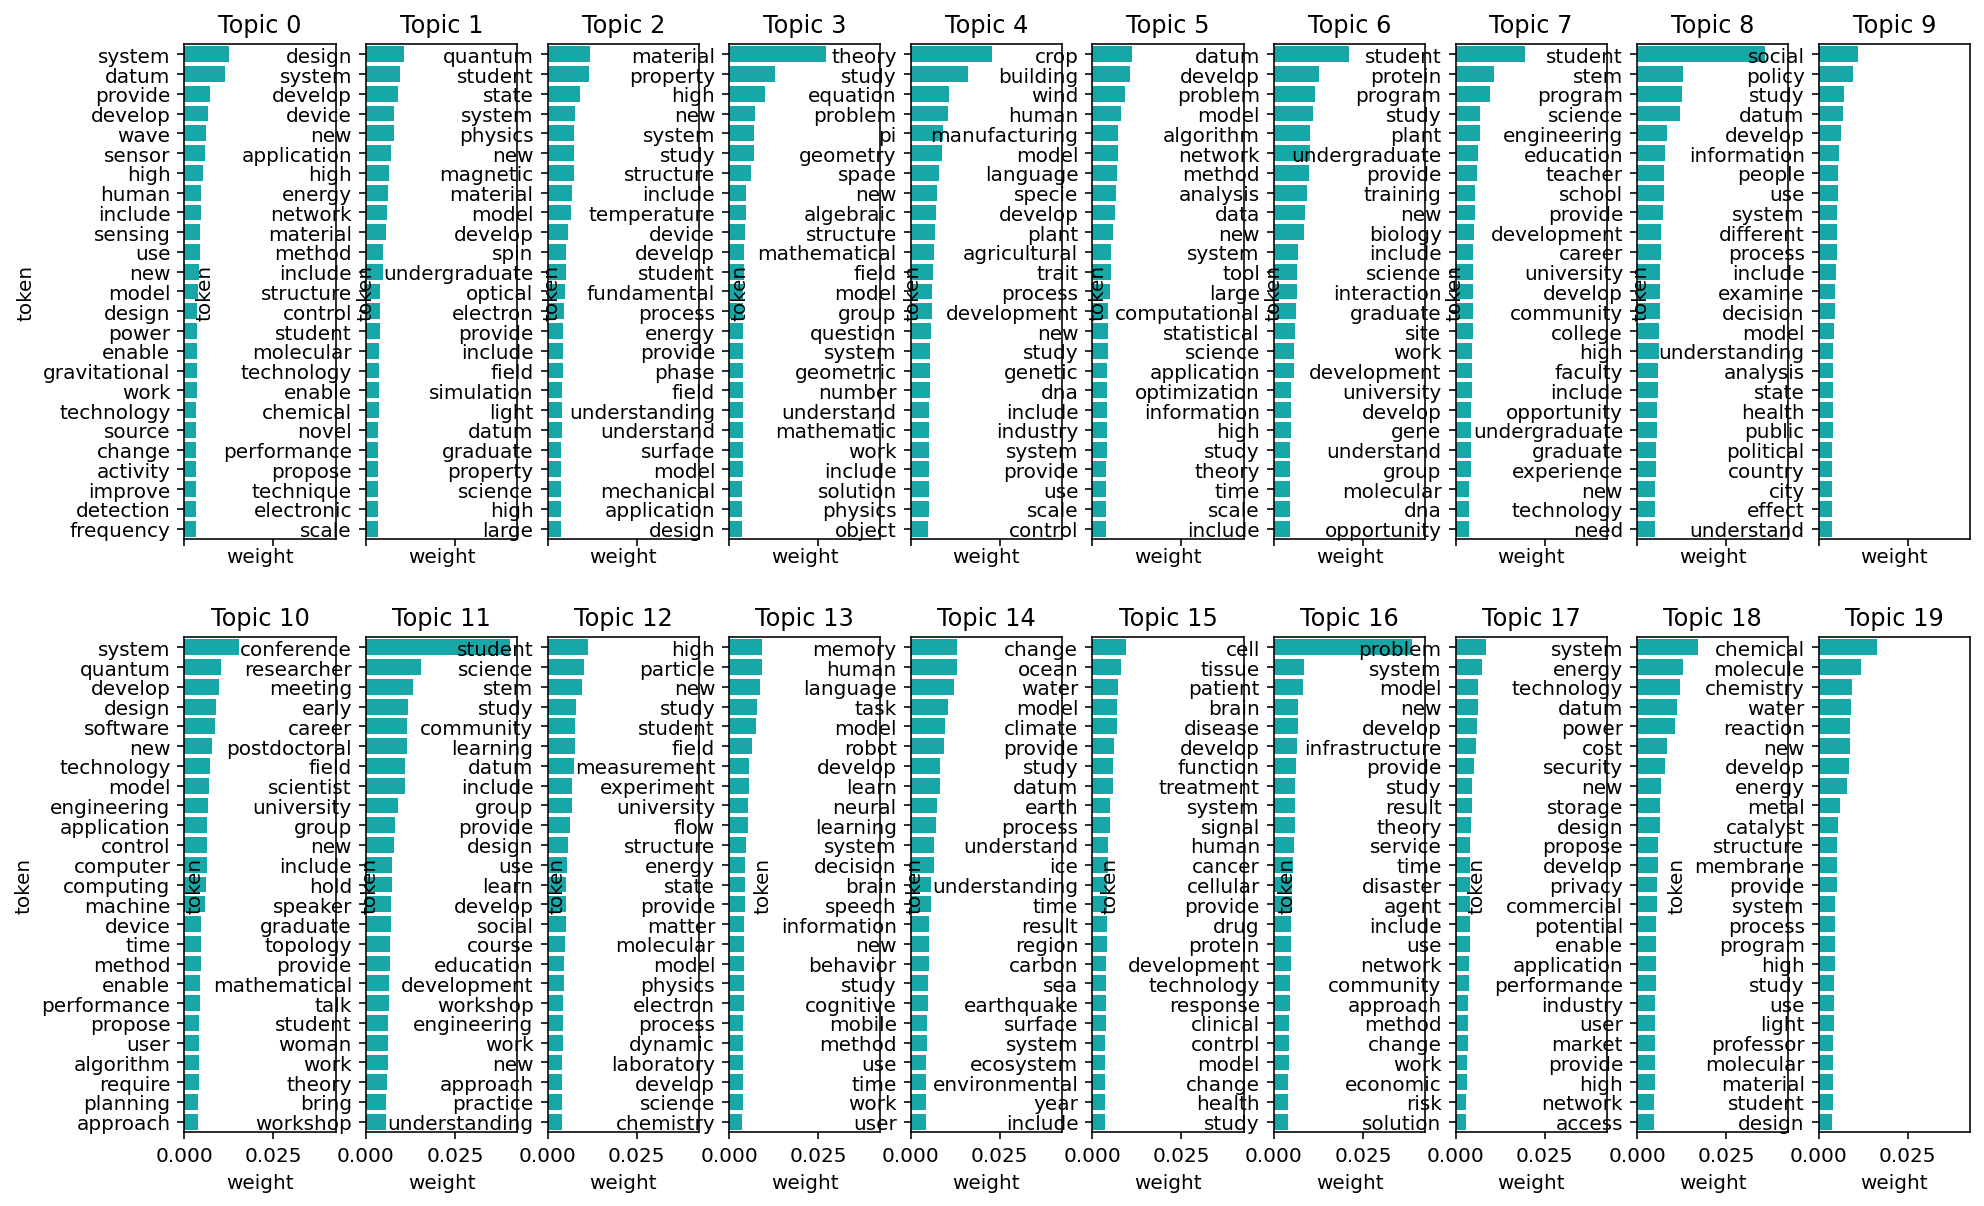

In [ ]:
#<SOL>
topn = 25

fig, axes = plt.subplots(2, 10, figsize=(16, 10), sharex=True)

for i in range(10):

    #<SOL>
    # Build a dataframe with columns 'token' and 'weight' for topic i
    df =  pd.DataFrame(ldag.show_topic(i, topn = 25), columns =['token', 'weight'])
    #</SOL>
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))
    #<SOL>
    # Build a dataframe with columns 'token' and 'weight' for topic i + 10
    df = pd.DataFrame(ldag.show_topic(i+10, topn = 25), columns =['token', 'weight'])
    #</SOL>
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+10))
    
plt.show()


#</SOL>

**Discussion**:

   - Having a look a the token composition of the obtained topics, do you consider all of them equally informative, in the sense of semantic relevance?
   - Can you think of any strategy to improve the quality of the topics in terms of their token description?

#### 3.2.2. LDA model visualization: pyLDAvis

A more useful visualization is provided by the python LDA visualization library, pyLDAvis.

To execute the next code fragment you need to have pyLDAvis installed.

A brief but complete description of the information provided by LDAvis can be found [here](https://pahulpreet86.github.io/interpreting-topic-model-visualization-ldavis-package/).

---
**Important:**

Note that pyLDAvis sorts the topics according to their size in the model, so there is not a direct correspondence between the order of topics in the ldag model and pyLDAvis topic numbering

---

In [ ]:
# Install of a visualizer for LDA
!pip install pyLDAvis==2.1.2

In [ ]:
# import pyLDAvis.gensim as gensimvis  # ?
import pyLDAvis
from pyLDAvis import gensim_models as gensimvis

vis_data = gensimvis.prepare(ldag, mycorpus_bow, D)
pyLDAvis.display(vis_data)

#### 3.2.3. Displaying document topic information

**Exercise 9**: If you have completed the exercises proposed in the notebook, you will already understand how you can work with the ldag model created in the previous subsection, and how it can be used to transform the document corpus.

   - Obtain the vector representation of the corpus according to the assignment of documents to topics provided by the model.

   - Obtain and view some of the most relevant documents for a topic of your choice

**Exercise 10**: Build a function that returns the most relevant projects for a given topic


In [ ]:
def most_relevant_documents(ldag, topicid, corpus_bow, ndocs=10):
    """This function returns the most relevant documents in corpus_bow

    : ldag: The trained topic model object provided by gensim
    : topicid: The topic for which we want to find the most relevant documents
    : corpus_bow: The BoW representation of documents in Gensim format
    : ndocs: Number of most relevant documents to return

    : Returns: A list with the identifiers of the most relevant documents
    """

    print('Computing most relevant documents for Topic', topicid)
    print('Topic composition is:')
    print(ldag.show_topic(topicid))

    lda_dense=matutils.corpus2dense(corpus_bow,num_terms=ldag.num_terms,num_docs=len(corpus_bow))
    selected_doc=np.argsort(lda_dense[topicid,:])[::-1]

    return selected_doc[0:ndocs]
    #</SOL>

#To test the function we will find the most relevant projects for one of the topics
project_id = most_relevant_documents(ldag, 8, mycorpus_bow, ndocs=3)

#Print titles of selected projects
for idproject in project_id:
    print('\n', ' '.join(mycorpus[idproject]))

#### 3.2.4. Using coherence to adjust the number of topics

One of the key questions when dealing with topic models is how to adjust the number of topics. There is usually a lot of trial and error in the process:

   - A too large number of topics allows to discover very detailed topics at the cost of the encountering also some unimportant and redundant topics
   - A small number normally provides semantic meaningful topics, but probably too broad. In addition to this, *garbage* topics can be seen even in this case.

A useful tool for selecting LDA hyperparameters is to use [Coherence models](https://radimrehurek.com/gensim/models/coherencemodel.html). But note that even these metrics are subject to a lot of controversy:
   - First of all, topics and model quality can be perceived in different ways by different people.
   - Second, some studies show that some coherence functions are not well correlated to human intuition when compared to the opinion of a pool of evaluators.


In [ ]:
from gensim.models.coherencemodel import CoherenceModel

coherencemodel = CoherenceModel(ldag, texts=mycorpus, dictionary=D, coherence='c_v')
print('The coherence of the trained model is', coherencemodel.get_coherence())

The coherence of the trained model is 0.41012414960866794


**Exercise 11**: Evaluate the evolution of topic coherence as a function of the number of topics. You can use, e.g.,

   - `n_topics = [5, 10, 15, 20, 25, 50]`. If the coherence does not achieve a local maximum, increase the number of topics to observe 
   - Different coherence measures are implemented in Gensim. Be aware that some coherence models (like `c_v`) take a significant time to compute.


Estimating coherence for a model with 5 topics
Estimating coherence for a model with 10 topics
Estimating coherence for a model with 15 topics
Estimating coherence for a model with 20 topics
Estimating coherence for a model with 25 topics
Estimating coherence for a model with 50 topics


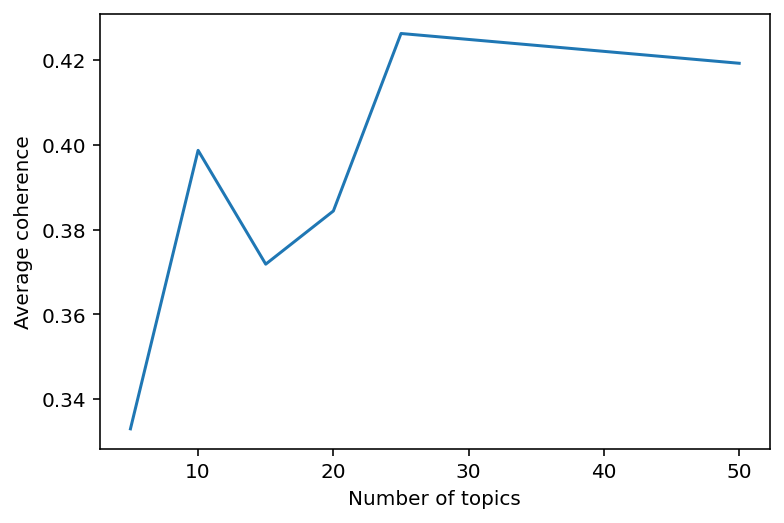

In [ ]:
#<SOL>
n_topics = [5, 10, 15, 20, 25, 50]
tc = []

for ntpc in n_topics:
  print('Estimating coherence for a model with',ntpc,'topics')
  lda_ntcp = LdaModel(corpus=mycorpus_bow,id2word=D,num_topics=ntpc)
  tc.append(CoherenceModel(lda_ntcp,texts=mycorpus,dictionary= D,coherence='c_v').get_coherence())

plt.plot(n_topics,tc)
plt.xlabel('Number of topics')
plt.ylabel('Average coherence')
plt.show()

Apart from estimating the average coherence of the model topics, we can also use the method `get_coherence_per_topic` to select the topics with largest coherence.

**Exercise 12**: For trained model `ldag` sort the topics according to their coherence, and check whether the most coherent topics are also the ones with a more relevant semantic value from your point of view.


#### 3.2.5. Training LDA with Mallet

As we have already explained, Mallet is a Java-based LDA implementation. It is based on Monte Carlo optimization which allows high parallelization. In addition, it generally offers very good results.

The recommended way to run Mallet is to install the executables in a local environment to be able to use it without any overhead as it happens when we use the wrapper provided by Gensim. Said wrapper requires generating auxiliary text files that are later used for Mallet training, and then the Mallet output must be parsed to retrieve the relevant information. Therefore, for a more efficient application it is more appropriate to launch Mallet executables directly. If you want to integrate such topic modeling into a Python application, you would just have to use one of the different tools that allow you to launch external processes from Python.

Despite the previous recommendation, for greater simplicity, within this notebook we will resort to the gensim wrapper, which allows us to make use of practically all the tools that we have already reviewed. However, running Mallet requires its installation in Google Colab, as well as a Java virtual machine, which we do in the following cells. We acknowledge here [this Github repository](https://github.com/polsci/colab-gensim-mallet/) from which we obtained the code.


In [ ]:
import os       #importing os to set environment variable
def install_java():
    !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
    !java -version       #check java version
install_java()

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
os.environ['MALLET_HOME'] = 'mallet-2.0.8'
mallet_path = 'mallet-2.0.8/bin/mallet' # you should NOT need to change this 

Now we are ready to train the LDA model in pretty much the same way we did for Mallet. We adjusted two additional Mallet parameters from their default values:

   - alpha: A priori hyperparameter for the Dirichlet distribution for generating the document topic distributions
   - iterations: To get a faster execution we reduce it to 100 from its default value of 1000. In principle, more iterations provide a more accurate solution.

It should be noted that Mallet has a lot of hyperparameters that can be adjusted for data import and model training. Many but not all of them are available when using the Gensim wrapper.

In [ ]:
from gensim.models.wrappers import LdaMallet
ldamallet = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=20, id2word=D, alpha=5, iterations=100)


To visualize the topics obtained by LDA using Mallet, you can use any of the visualization strategies already studied in the previous subsections. However, if you wish to use pyLDAvis, it is important that you convert `ldamallet` model to an object that is fully compatible with Gensim

In [ ]:
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
ldagensim = malletmodel2ldamodel(ldamallet)

In [ ]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

vis_data = gensimvis.prepare(ldagensim, mycorpus_bow, D)
pyLDAvis.display(vis_data)

You can also use functions to compute the coherence of the topics. The following cell computes the coherence of the model trained with Mallet. You can compare this value to the coherence obtained using the Gensim LDA implementation.

In [ ]:
coherencemodel = CoherenceModel(ldagensim, texts=mycorpus, dictionary=D, coherence='c_v')
print(coherencemodel.get_coherence())

**Exercise 13**: Compute the coherence of the LDA models trained using the Mallet implementation for different number of topics, and compare this result with the observed coherences for the Gensim implementation.

## **4. Semantic Similarity**
---

It is easy to semantically compare the topics of one or more topic models based on the composition of said topics, or to compare documents based on their vector representation provided by the LDA algorithm.

   - Topic representation: A vector of length equal to the number of tokens in the vocabulary, indicating the relevance of each token for the topic.
   - Document representation: A vector of length equal to the number of topics in the model, indicating the proportion of each topic in the document.

To make the comparison we could use any measure of distance between vectors. However, given that both the vector and document representations have the form of a probability vector (all its components are non-negative and of unit sum), it is more appropriate to use measures that allow comparison of probability distributions such as the Kullback-Leibler, Jensen-Shannon, or Hellinger distance. Among them, we will keep the Hellinger distance because it has a similar behavior to that of Jensen-Shannon and is much easier to calculate.

### *4.1. The Hellinger distance*

Different versions of the Hellinger distance are used by different authors, in this notebook we will use
$$H({\bf p}, {\bf q}) = \left[ \frac{1}{2} \sum_i (\sqrt{p_i} - \sqrt{q_i})^2 \right]^{\frac{1}{2}}$$

where $\bf p$ and $\bf q$ are the two vectors (of equal length) to be compared.

Taking into account that the components of $\bf p$ and $\bf q$ sum up to 1, Hellinger distance can be implemented more efficiently as

$$H({\bf p}, {\bf q}) = \sqrt{ 1 - B({\bf p}, {\bf q})} $$

with 
$$B({\bf p}, {\bf q}) = \sum_i\sqrt{p_i q_i}$$


where $B({\bf p}, {\bf q})$ is known as the Bhattacharyya’s coefficient, and can be thought of as similarity matrix.


From their definitions, it can be seen that both $H({\bf p}, {\bf q})$ and $B({\bf p}, {\bf q})$ lie in interval $[0,1]$, and we will use one or the other depending on whether we need a similarity or a distance measure.

Not that computation of $B({\bf p}, {\bf q})$ for all pairs of documents (or topics) can be implemented very easily in Python as a product of matrices.

For instance, if variable `X` contains a numpy array with the vector representation of all documents provided by a certain LDA model, we could compute the semantic similarity between any pair of documents as

```
sqrtX = np.sqrt(X)
docsim = sqrtX.dot(sqrtX.T)
```

Here, we are assuming that the shape of `X` is $ndocs \times ntopics"$.

### *4.2. Distances between LDA topics*

The following piece of code computes the distances between the topic models `ldag` and `ldagensim` (the one we computed with Mallet implementation).

Taking a look at the plotted matrix, we can see that some pairs of topics have a relatively low distance, and could be thougt as equivalent topics if we were to match topics from both models.

In [ ]:
distmat, annotations = ldag.diff(ldagensim, distance='hellinger', num_words=100)

plt.imshow(distmat)
plt.colorbar()
plt.show()

**Exercise 14:** Find the closest topics from models `ldag` and `ldagensim`, and print their topic composition to check whether they seem similar from the perspective of the most relevant tokens for each topic.

In [ ]:
#<SOL>


#</SOL>

### *4.3. Similarity among documents using an LDA model*

Gensim provides different functions that allow you to easily implement the similarity calculation between documents. In future sessions we will represent document graphs whose links are obtained from the semantic similarity between documents. For this reason, we need to calculate the distance between each pair of documents, and the direct implementation using matrix calculation is more efficient.

Note, however, that this implementation requires that the data matrix and the similarity matrix itself be stored in RAM memory, so this approach would not be viable in the case of large data corpus. In these cases, it would be necessary to implement specific strategies based, for example, on the block calculation of the similarity matrix or on the sampling or thresholding of the similarities between pairs of documents.

In [ ]:
from gensim.matutils import corpus2csc

X = corpus2csc(ldagensim[mycorpus_bow])
sqrtX = np.sqrt(X)
simmat = sqrtX.T.dot(sqrtX)

print('Number of non-zero components in similarity matrix:', len(simmat.data))
print('We check the size of the similarity matrix:', simmat.shape)
print('Ratio of non-zero components:', len(simmat.data)/simmat.shape[0]/simmat.shape[1])

**Exercise 15:** Implement a function that prints the most similar documents given a reference document by its position in the corpus. You may try running the function for different documents, and check also if the similarities inferred from the `ldag` or `ldagensim` (trained using Mallet) result in some significant differences regarding the retrieved documents.

In [ ]:
def print_most_similar(corpus, simmat, docid, topn=5):
    """Print most similar documents to docid, according to the provided similarity matrix
    :corpus: Original corpus
    :simmat: Calculated similarity matrix
    :docid:  Reference document for similarity search
    :topn:   Number of most similar documents to print (including ref doc)
    """
    #<SOL>
    
    
    #</SOL>

print_most_similar(mycorpus, simmat, 4281)